
Sentiment Analysis on IMDB movie reviews

Ali Rabiee 

# Requirements & Import libraries

In [ ]:
# Requirements
!pip install unidecode
!pip install word2number
!pip install contractions
!pip install pyspellchecker

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from bs4 import BeautifulSoup
import spacy
import unidecode
from word2number import w2n
import contractions
from collections import Counter
from spellchecker import SpellChecker
import re
import string 
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer 
import gensim
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from prettytable import PrettyTable
from sklearn.neural_network import MLPClassifier
import pickle

# 1. Data pre-processing

Due to the large amount of the dataset, I import it from my drive.

In [ ]:
# Importing the training data

# data = pd.read_csv("dataset.csv")
from google.colab import drive
drive.mount('/content/gdrive')
data = pd.read_csv('/content/gdrive/My Drive/Datasets/dataset.csv')

Mounted at /content/gdrive


In [ ]:
# Summary of the dataset
data.describe()

,comment,sentiment
count,45000,45000
unique,44664,2
top,Loved today's show!!! It was a variety and not...,positive
freq,4,22501


In [ ]:
# Sentiment count
data['sentiment'].value_counts()

positive    22501
negative    22499
Name: sentiment, dtype: int64

In [ ]:
# top 10 elements of the dataset
data.head(10)

,comment,sentiment
0,"Oh my god, it just doesn't get any worse than ...",negative
1,If you're a layman interested in quantum theor...,negative
2,It's amazing that this no talent actor Chapa g...,negative
3,This must be one of the most overrated Spanish...,negative
4,Some critics have compared Chop Shop with the ...,positive
5,Roll up! Roll up! It's Big Gay Bruce and his B...,negative
6,"""House Of Games"" is definitely not without its...",positive
7,It's a simple fact that there are many of us f...,positive
8,"I think this is a great, classic monster film ...",positive
9,"I saw this film over Christmas, and what a gre...",positive


In [ ]:
# convert sentiment results to number {0,1}
data['sentiment'].replace('negative',0,inplace=True)
data['sentiment'].replace('positive',1,inplace=True)

## Low Level Pre-processing

In [ ]:
def low_lvl_preprocessing(text):

    # Lower-case
    cleaned_text = text.lower()

    # Expand shortened words, e.g. don't to do not
    cleaned_text = contractions.fix(cleaned_text)

    # Remove numbers from comments
    cleaned_text = cleaned_text.replace('\d+', '')

    # Remove special characters
    cleaned_text = re.sub('\[.*?\]', '', cleaned_text)
    cleaned_text = re.sub('[%s]'%re.escape(string.punctuation), '', cleaned_text)
    cleaned_text = re.sub('\w*\d\w*', '', cleaned_text)
    cleaned_text = re.sub('[''"",,,]', '', cleaned_text)
    cleaned_text = re.sub('\n', '', cleaned_text)
    cleaned_text = re.sub('[^A-Za-z0-9 ]+', '', cleaned_text)

    # Remove the punctuation =>  !"#$%&\'()*+,-./:;<=>?@[\\]^_{|}~`
    PUNCT_TO_REMOVE = string.punctuation
    cleaned_text = text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

    return cleaned_text

In [ ]:
cleaned1 = lambda x:low_lvl_preprocessing(x)
data1 = data.copy()
data1['comment'] = pd.DataFrame(data.comment.apply(cleaned1))
data1.head(10)

,comment,sentiment
0,Oh my god it just doesnt get any worse than th...,0
1,If youre a layman interested in quantum theory...,0
2,Its amazing that this no talent actor Chapa go...,0
3,This must be one of the most overrated Spanish...,0
4,Some critics have compared Chop Shop with the ...,1
5,Roll up Roll up Its Big Gay Bruce and his Big ...,0
6,House Of Games is definitely not without its f...,1
7,Its a simple fact that there are many of us fr...,1
8,I think this is a great classic monster film f...,1
9,I saw this film over Christmas and what a grea...,1


## High Level Pre-processing

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
def high_lvl_preprocessing(text):
    
    cleaned_text = text
    
    # Remove accented characters from text, e.g. café
    cleaned_text = unidecode.unidecode(cleaned_text)
    
    # Removal of Emojis
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    cleaned_text = emoji_pattern.sub(r'', cleaned_text)
    
    # Removal of URLs
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    cleaned_text = url_pattern.sub(r'', cleaned_text)
    
    # Stop words removal
    STOPWORDS = stopwords.words('english')
    cleaned_text = " ".join([word for word in str(cleaned_text).split() if word not in STOPWORDS])

    # lemma
    lemmatizer = WordNetLemmatizer()
    cleaned_text = " ".join([lemmatizer.lemmatize(word) for word in cleaned_text.split()])

    # stemming
    stemmer = PorterStemmer()
    cleaned_text = " ".join([stemmer.stem(word) for word in cleaned_text.split()])

    return cleaned_text

In [ ]:
cleaned2 = lambda x:high_lvl_preprocessing(x)
data2 = data1.copy()
data2['comment'] = pd.DataFrame(data1.comment.apply(cleaned2))
data2.head(10)

,comment,sentiment
0,Oh god doesnt get wors I alway love silli litt...,0
1,If your layman interest quantum theori string ...,0
2,it amaz talent actor chapa got well known star...,0
3,thi must one overr spanish film histori it lac...,0
4,some critic compar chop shop theatric releas c...,1
5,roll roll it big gay bruce big gay death canno...,0
6,hous Of game definit without flaw plot hole st...,1
7,it simpl fact mani u 80 gener grew love loopi ...,1
8,I think great classic monster film famili the ...,1
9,I saw film christma great film It tell stori c...,1


In [ ]:
# Word tokenize

data1['comment'] = data1['comment'].apply(word_tokenize)
data2['comment'] = data2['comment'].apply(word_tokenize)
data2.head()

,comment,sentiment
0,"[Oh, god, doesnt, get, wors, I, alway, love, s...",0
1,"[If, your, layman, interest, quantum, theori, ...",0
2,"[it, amaz, talent, actor, chapa, got, well, kn...",0
3,"[thi, must, one, overr, spanish, film, histori...",0
4,"[some, critic, compar, chop, shop, theatric, r...",1


In [ ]:
# Removal of Frequent words
cnt = Counter()
for text in data2["comment"].values:
    for word in text:
        cnt[word] += 1
cnt.most_common(10)

[('I', 128522),
 ('br', 102377),
 ('movi', 89110),
 ('film', 82956),
 ('the', 82612),
 ('one', 47965),
 ('like', 39611),
 ('time', 26895),
 ('thi', 26728),
 ('good', 26192)]

In [ ]:
# Remove top 10 frequent words 

freq_words = [x for i, x in enumerate(cnt.most_common(10)) if i!=4 and i!=6 and i!=9]
FREQWORDS = set([w for (w, wc) in freq_words])

def remove_freqwords(text):
    return list([word for word in text if word not in FREQWORDS])

data2["comment"] = data2["comment"].apply(lambda text: remove_freqwords(text))
data2.head()

,comment,sentiment
0,"[Oh, god, doesnt, get, wors, alway, love, sill...",0
1,"[If, your, layman, interest, quantum, theori, ...",0
2,"[it, amaz, talent, actor, chapa, got, well, kn...",0
3,"[must, overr, spanish, histori, it, lack, subt...",0
4,"[some, critic, compar, chop, shop, theatric, r...",1


In [ ]:
# Removal of Rare words

n_rare_words = 10
RAREWORDS = set([w for (w, wc) in cnt.most_common()[:-n_rare_words-1:-1]])

def remove_rarewords(text):
    return list([word for word in text if word not in RAREWORDS])

data2["comment"] = data2["comment"].apply(lambda text: remove_rarewords(text))
data2.head()

,comment,sentiment
0,"[Oh, god, doesnt, get, wors, alway, love, sill...",0
1,"[If, your, layman, interest, quantum, theori, ...",0
2,"[it, amaz, talent, actor, chapa, got, well, kn...",0
3,"[must, overr, spanish, histori, it, lack, subt...",0
4,"[some, critic, compar, chop, shop, theatric, r...",1


# 2. Vectorization

## BOW

In [ ]:
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000)

# Without any pre-process
bow = bow_vectorizer.fit_transform(data['comment'])

# With low pre-process
data1_comments = [' '.join([str(elem) for elem in sublist]) for sublist in data1['comment']]
bow1 = bow_vectorizer.fit_transform(data1_comments)

# With high pre-process
data2_comments = [' '.join([str(elem) for elem in sublist]) for sublist in data2['comment']]
bow2 = bow_vectorizer.fit_transform(data2_comments)

pickle.dump(bow_vectorizer, open('bow_vectorizer.pkl','wb'))

In [ ]:
bow2.shape

(45000, 1000)

In [ ]:
# save bow vector for next phase
with open('bow.npy', 'wb') as f:
    np.save(f, bow2.toarray(), allow_pickle=True)

## Word2Vec

In [ ]:
# Without any pre-process
w2v = gensim.models.Word2Vec(data['comment'], min_count=20, size=200, workers=8)

# With low pre-process
w2v_1 = gensim.models.Word2Vec(data1['comment'], min_count=20, size=200, workers=8)

# With high pre-process
w2v_2 = gensim.models.Word2Vec(data2['comment'], min_count=20, size=200, workers=8)

In [ ]:
# Create a vector for each comment

def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0
    for word in tokens:
        try:
            vec += w2v_2[word].reshape((1, size))
            count += 1.
        except KeyError:  
            continue
    if count != 0:
        vec /= count
    return vec

wordvec = np.zeros((len(data2['comment']), 200)) 

for i in range(len(data2['comment'])):
    wordvec[i,:] = word_vector(data2['comment'][i], 200)

wordvec2 = pd.DataFrame(wordvec)


In [ ]:
wordvec2.shape

(45000, 200)

In [ ]:
# save w2v vector for next phase
with open('w2v.npy', 'wb') as f:
    np.save(f, wordvec2, allow_pickle=True)

# 3. Evaluation of the performance of pre-processing methods 

In [ ]:
# Split dataset

# Without any pre-process
X, y = bow, data['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

# With low pre-process
X1, y1 = bow1, data1['sentiment']
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, train_size=0.8)

# With high pre-process
X2, y2 = bow2, data2['sentiment']
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, train_size=0.8)

In [ ]:
# Define a def for scores

def analysis(labels, predictions):
    print(f"Report: Classification\n{classification_report(labels, predictions, target_names=['positive','negative'])}")
    confusion_matrix = pd.DataFrame(metrics.confusion_matrix(labels, predictions)) 
    sns.heatmap(confusion_matrix, annot=True, cmap="Blues");
    print(f"Accuracy: {accuracy_score(labels, predictions):.6f}")
    print("Precision:{:.6f}".format(metrics.precision_score(labels, predictions)))
    print("Recall:{:.6f}".format(metrics.recall_score(labels, predictions)))
    print("F1 score:{:.6f}".format(metrics.f1_score(labels, predictions)))

## Logistic Regression

Report: Classification
              precision    recall  f1-score   support

    positive       0.79      0.82      0.80      4270
    negative       0.83      0.80      0.81      4730

    accuracy                           0.81      9000
   macro avg       0.81      0.81      0.81      9000
weighted avg       0.81      0.81      0.81      9000

Accuracy: 0.809222
Precision:0.832341
Recall:0.797674
F1 score:0.814639


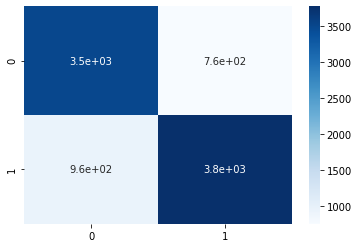

In [ ]:
# Without any pre-process
lr = LogisticRegression(C=0.05)
lr.fit(X, y)
pred = lr.predict(X_test)
analysis(pred, y_test)

Report: Classification
              precision    recall  f1-score   support

    positive       0.84      0.86      0.85      4413
    negative       0.86      0.84      0.85      4587

    accuracy                           0.85      9000
   macro avg       0.85      0.85      0.85      9000
weighted avg       0.85      0.85      0.85      9000

Accuracy: 0.849667
Precision:0.863371
Recall:0.837584
F1 score:0.850282


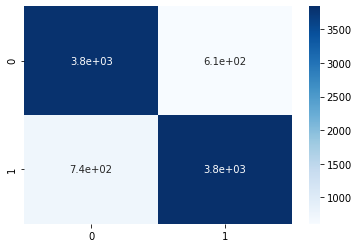

In [ ]:
# With low pre-process
lr1 = LogisticRegression(C=0.05)
lr1.fit(X1, y1)
pred1 = lr1.predict(X_test1)
analysis(pred1, y_test1)

Report: Classification
              precision    recall  f1-score   support

    positive       0.86      0.88      0.87      4432
    negative       0.88      0.86      0.87      4568

    accuracy                           0.87      9000
   macro avg       0.87      0.87      0.87      9000
weighted avg       0.87      0.87      0.87      9000

Accuracy: 0.870333
Precision:0.880681
Recall:0.861208
F1 score:0.870836


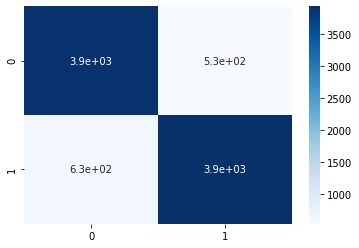

In [ ]:
# With high pre-process
lr2 = LogisticRegression(C=0.05)
lr2.fit(X2, y2)
pred2 = lr2.predict(X_test2)
analysis(pred2, y_test2)

In [ ]:
# Comparison

LR_dic = {}
LR_dic['LR without preprocess'] = metrics.accuracy_score(y_test, pred)
LR_dic['LR with low preprocess'] = metrics.accuracy_score(y_test1, pred1)
LR_dic['LR with high preprocess'] = metrics.accuracy_score(y_test2, pred2)

t = PrettyTable(['model', 'accuracy'])
for key, val in LR_dic.items():
   t.add_row([key, val])
   
print(t)

+-------------------------+--------------------+
|          model          |      accuracy      |
+-------------------------+--------------------+
|  LR without preprocess  | 0.8092222222222222 |
|  LR with low preprocess | 0.8496666666666667 |
| LR with high preprocess | 0.8703333333333333 |
+-------------------------+--------------------+


## KNN

Report: Classification
              precision    recall  f1-score   support

    positive       0.75      0.74      0.75      4469
    negative       0.75      0.75      0.75      4531

    accuracy                           0.75      9000
   macro avg       0.75      0.75      0.75      9000
weighted avg       0.75      0.75      0.75      9000

Accuracy: 0.746889
Precision:0.748511
Recall:0.748841
F1 score:0.748676


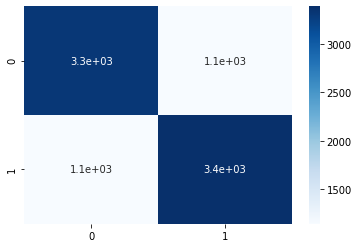

In [ ]:
# Without any pre-process
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X, y)
pred = knn.predict(X_test)
analysis(pred, y_test)

Report: Classification
              precision    recall  f1-score   support

    positive       0.68      0.80      0.73      3868
    negative       0.82      0.72      0.77      5132

    accuracy                           0.75      9000
   macro avg       0.75      0.76      0.75      9000
weighted avg       0.76      0.75      0.75      9000

Accuracy: 0.751111
Precision:0.824944
Recall:0.715316
F1 score:0.766228


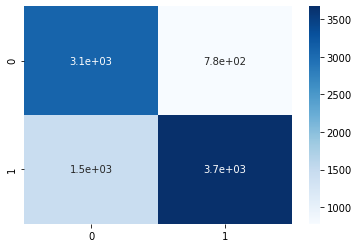

In [ ]:
# With Low pre-process
knn1 = KNeighborsClassifier(n_neighbors=7)
knn1.fit(X1, y1)
pred1 = knn1.predict(X_test1)
analysis(pred1, y_test1)

Report: Classification
              precision    recall  f1-score   support

    positive       0.76      0.77      0.77      4496
    negative       0.77      0.76      0.76      4504

    accuracy                           0.77      9000
   macro avg       0.77      0.77      0.77      9000
weighted avg       0.77      0.77      0.77      9000

Accuracy: 0.765667
Precision:0.768077
Recall:0.761767
F1 score:0.764909


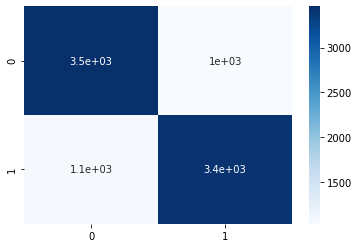

In [ ]:
# With high pre-process
knn2 = KNeighborsClassifier(n_neighbors=11)
knn2.fit(X2, y2)
pred2 = knn2.predict(X_test2)
analysis(pred2, y_test2)

In [ ]:
# Comparison

knn_dic = {}
knn_dic['knn without preprocess'] = metrics.accuracy_score(y_test, pred)
knn_dic['knn with low preprocess'] = metrics.accuracy_score(y_test1, pred1)
knn_dic['knn with high preprocess'] = metrics.accuracy_score(y_test2, pred2)

t = PrettyTable(['model', 'accuracy'])
for key, val in knn_dic.items():
   t.add_row([key, val])
   
print(t)

+--------------------------+--------------------+
|          model           |      accuracy      |
+--------------------------+--------------------+
|  knn without preprocess  | 0.7468888888888889 |
| knn with low preprocess  | 0.7511111111111111 |
| knn with high preprocess | 0.7656666666666667 |
+--------------------------+--------------------+


## SVM

Report: Classification
              precision    recall  f1-score   support

    positive       0.88      0.87      0.87      4564
    negative       0.87      0.87      0.87      4436

    accuracy                           0.87      9000
   macro avg       0.87      0.87      0.87      9000
weighted avg       0.87      0.87      0.87      9000

Accuracy: 0.872111
Precision:0.868687
Recall:0.872408
F1 score:0.870543


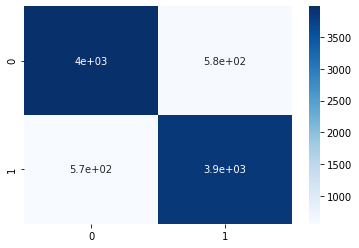

In [ ]:
# Without any pre-process
model = SGDClassifier()
model.fit(X, y)
pred = model.predict(X_test)
analysis(pred, y_test)

Report: Classification
              precision    recall  f1-score   support

    positive       0.85      0.88      0.87      4368
    negative       0.88      0.86      0.87      4632

    accuracy                           0.87      9000
   macro avg       0.87      0.87      0.87      9000
weighted avg       0.87      0.87      0.87      9000

Accuracy: 0.868778
Precision:0.882679
Recall:0.859240
F1 score:0.870802


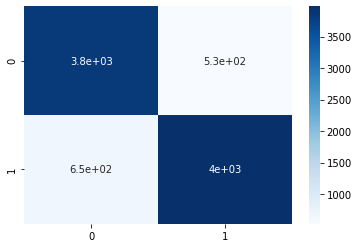

In [ ]:
# With low pre-process
model1 = SGDClassifier()
model1.fit(X1, y1)
pred1 = model1.predict(X_test1)
analysis(pred1, y_test1)

Report: Classification
              precision    recall  f1-score   support

    positive       0.83      0.90      0.86      4185
    negative       0.90      0.84      0.87      4815

    accuracy                           0.86      9000
   macro avg       0.87      0.87      0.86      9000
weighted avg       0.87      0.86      0.86      9000

Accuracy: 0.864556
Precision:0.904408
Recall:0.835099
F1 score:0.868373


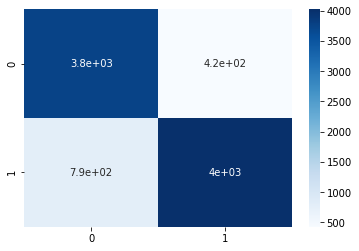

In [ ]:
# With high pre-process
model2 = SGDClassifier()
model2.fit(X2, y2)
pred2 = model2.predict(X_test2)
analysis(pred2, y_test2)

In [ ]:
# Comparison

svm_dic = {}
svm_dic['svm without preprocess'] = metrics.accuracy_score(y_test, pred)
svm_dic['svm with low preprocess'] = metrics.accuracy_score(y_test1, pred1)
svm_dic['svm with high preprocess'] = metrics.accuracy_score(y_test2, pred2)

t = PrettyTable(['model', 'accuracy'])
for key, val in svm_dic.items():
   t.add_row([key, val])
   
print(t)

+--------------------------+--------------------+
|          model           |      accuracy      |
+--------------------------+--------------------+
|  svm without preprocess  | 0.8721111111111111 |
| svm with low preprocess  | 0.8687777777777778 |
| svm with high preprocess | 0.8645555555555555 |
+--------------------------+--------------------+


# 4. Evaluation of the performance of vectorization methods and fine-tuning hyperparameters

In [ ]:
# Split Dataset for w2v method

X3, y3 = wordvec2, data2['sentiment'] 
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, train_size=0.8)

## Logistic Regression

Report: Classification
              precision    recall  f1-score   support

    positive       0.86      0.87      0.87      4468
    negative       0.87      0.86      0.87      4532

    accuracy                           0.87      9000
   macro avg       0.87      0.87      0.87      9000
weighted avg       0.87      0.87      0.87      9000

Accuracy: 0.866556
Precision:0.872179
Recall:0.861209
F1 score:0.866659


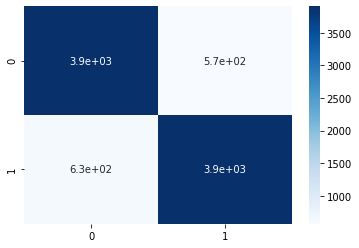

In [ ]:
# With BOW
lr_bow = LogisticRegression(C=0.2)
lr_bow.fit(X2, y2)
lr_pred_bow = lr_bow.predict(X_test2)
analysis(lr_pred_bow, y_test2)

Report: Classification
              precision    recall  f1-score   support

    positive       0.86      0.87      0.87      4454
    negative       0.87      0.87      0.87      4546

    accuracy                           0.87      9000
   macro avg       0.87      0.87      0.87      9000
weighted avg       0.87      0.87      0.87      9000

Accuracy: 0.866111
Precision:0.869008
Recall:0.865376
F1 score:0.867188


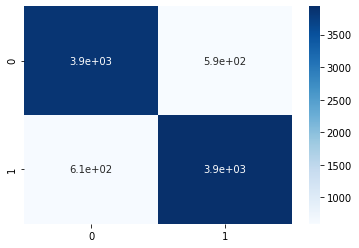

In [ ]:
# With w2v
lr_w2v = LogisticRegression(C=0.1)
lr_w2v.fit(X3, y3)
lr_pred_w2v = lr_w2v.predict(X_test3)
analysis(lr_pred_w2v, y_test3)

In [ ]:
# Comparison

lr_dic = {}
lr_dic['LR(BOW)'] = metrics.accuracy_score(y_test2, lr_pred_bow)
lr_dic['LR(w2v)'] = metrics.accuracy_score(y_test3, lr_pred_w2v)


t = PrettyTable(['model', 'accuracy'])
for key, val in lr_dic.items():
   t.add_row([key, val])
   
print(t)

+---------+--------------------+
|  model  |      accuracy      |
+---------+--------------------+
| LR(BOW) | 0.8665555555555555 |
| LR(w2v) | 0.8661111111111112 |
+---------+--------------------+


## KNN

Report: Classification
              precision    recall  f1-score   support

    positive       0.75      0.76      0.75      4404
    negative       0.77      0.76      0.76      4596

    accuracy                           0.76      9000
   macro avg       0.76      0.76      0.76      9000
weighted avg       0.76      0.76      0.76      9000

Accuracy: 0.758556
Precision:0.765273
Recall:0.760444
F1 score:0.762851


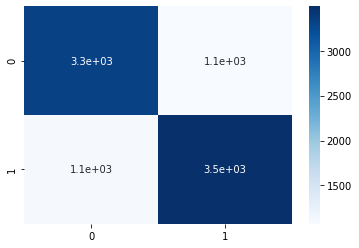

In [ ]:
# With BOW
knn_bow = KNeighborsClassifier(n_neighbors=11)
knn_bow.fit(X2, y2)
knn_pred_bow = knn_bow.predict(X_test2)
analysis(knn_pred_bow, y_test2)

Report: Classification
              precision    recall  f1-score   support

    positive       0.86      0.84      0.85      4734
    negative       0.82      0.85      0.84      4266

    accuracy                           0.84      9000
   macro avg       0.84      0.84      0.84      9000
weighted avg       0.85      0.84      0.84      9000

Accuracy: 0.844333
Precision:0.824022
Recall:0.853962
F1 score:0.838725


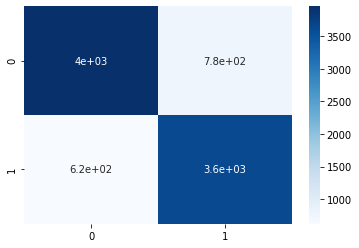

In [ ]:
# With w2v
knn_w2v = KNeighborsClassifier(n_neighbors=11)
knn_w2v.fit(X3, y3)
knn_pred_w2v = knn_w2v.predict(X_test3)
analysis(knn_pred_w2v, y_test3)

In [ ]:
# Comparison

knn_dic = {}
knn_dic['knn(BOW)'] = metrics.accuracy_score(y_test2, knn_pred_bow)
knn_dic['knn(w2v)'] = metrics.accuracy_score(y_test3, knn_pred_w2v)


t = PrettyTable(['model', 'accuracy'])
for key, val in knn_dic.items():
   t.add_row([key, val])
   
print(t)

+----------+--------------------+
|  model   |      accuracy      |
+----------+--------------------+
| knn(BOW) | 0.7585555555555555 |
| knn(w2v) | 0.8443333333333334 |
+----------+--------------------+


## SVM

Report: Classification
              precision    recall  f1-score   support

    positive       0.84      0.88      0.86      4332
    negative       0.89      0.85      0.87      4668

    accuracy                           0.87      9000
   macro avg       0.87      0.87      0.87      9000
weighted avg       0.87      0.87      0.87      9000

Accuracy: 0.865222
Precision:0.886034
Recall:0.849400
F1 score:0.867330


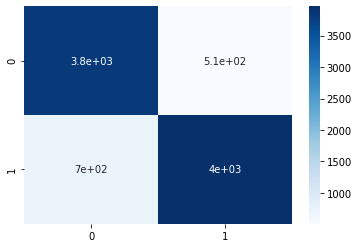

In [ ]:
# With BOW
svm_bow = SGDClassifier()
svm_bow.fit(X2, y2)
svm_pred_bow = svm_bow.predict(X_test2)
analysis(svm_pred_bow, y_test2)

Report: Classification
              precision    recall  f1-score   support

    positive       0.82      0.89      0.86      4124
    negative       0.90      0.84      0.87      4876

    accuracy                           0.86      9000
   macro avg       0.86      0.87      0.86      9000
weighted avg       0.87      0.86      0.86      9000

Accuracy: 0.864111
Precision:0.903468
Recall:0.838802
F1 score:0.869935


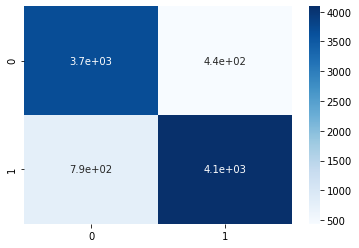

In [ ]:
# With w2v
svm_w2v = SGDClassifier()
svm_w2v.fit(X3, y3)
svm_pred_w2v = svm_w2v.predict(X_test3)
analysis(svm_pred_w2v, y_test3)

In [ ]:
# Comparison

svm_dic = {}
svm_dic['svm(BOW)'] = metrics.accuracy_score(y_test2, svm_pred_bow)
svm_dic['svm(w2v)'] = metrics.accuracy_score(y_test3, svm_pred_w2v)


t = PrettyTable(['model', 'accuracy'])
for key, val in svm_dic.items():
   t.add_row([key, val])
   
print(t)

+----------+--------------------+
|  model   |      accuracy      |
+----------+--------------------+
| svm(BOW) | 0.8652222222222222 |
| svm(w2v) | 0.8641111111111112 |
+----------+--------------------+


## Save best models

In [ ]:
# SAVE-LOAD using pickle 

# save LR(BoW) according to results
with open('LR.pkl', 'wb') as f:
    pickle.dump(lr_bow, f)

# save KNN(w2v) according to results
with open('KNN.pkl', 'wb') as f:
    pickle.dump(knn_w2v, f)

# save SVM(w2v) according to results
with open('SVM.pkl', 'wb') as f:
    pickle.dump(knn_bow, f)


# 5. MLP Approach

Report: Classification
              precision    recall  f1-score   support

    positive       0.85      0.84      0.84      4494
    negative       0.84      0.85      0.84      4506

    accuracy                           0.84      9000
   macro avg       0.84      0.84      0.84      9000
weighted avg       0.84      0.84      0.84      9000

Accuracy: 0.843778
Precision:0.839614
Recall:0.850422
F1 score:0.844983


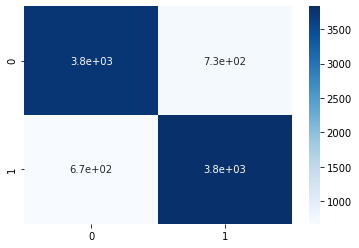

In [ ]:
'''
Parameters :
hidden_layer_sizes=150
activation='relu'
solver='adam'
L2 penalty (regularization term) parameter= 0.0001
Maximum number of iterations= 1000
'''
# with w2v

mlp = MLPClassifier(hidden_layer_sizes=150,
                    activation='relu',
                    solver='adam',
                    random_state=1,
                    max_iter=1000)

mlp.fit(X_train3, y_train3)

mlp_pred = mlp.predict(X_test3)
analysis(y_test3, mlp_pred)

Report: Classification
              precision    recall  f1-score   support

    positive       0.86      0.86      0.86      4433
    negative       0.87      0.87      0.87      4567

    accuracy                           0.86      9000
   macro avg       0.86      0.86      0.86      9000
weighted avg       0.86      0.86      0.86      9000

Accuracy: 0.864889
Precision:0.866390
Recall:0.867528
F1 score:0.866958


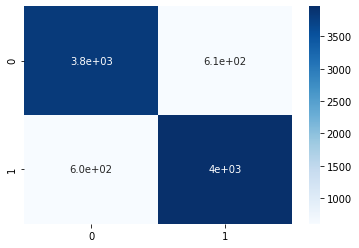

In [ ]:
'''
Parameters :
hidden_layer_sizes=150
activation='relu'
solver='adam'
L2 penalty (regularization term) parameter= 0.0001
Maximum number of iterations= 1000
'''
# with BOW

mlp = MLPClassifier(hidden_layer_sizes=150,
                    activation='relu',
                    solver='adam',
                    random_state=1,
                    max_iter=1000)

mlp.fit(X_train2, y_train2)

mlp_pred = mlp.predict(X_test2)
analysis(y_test2, mlp_pred)

In [ ]:
# Save model
with open('best.pkl', 'wb') as f:
    pickle.dump(mlp, f)